In [1]:
excel_file = "E-commerce_data.xlsx"

In [2]:
import pandas as pd

df_customers = pd.read_excel(excel_file, sheet_name="customers", engine="openpyxl")
df_transactions = pd.read_excel(excel_file, sheet_name="transactions", engine="openpyxl")

In [3]:
df_transactions.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6


In [4]:
df_transactions.shape

(5000, 7)

In [5]:
df_transactions['customer_id'].duplicated().sum()

4011

In [6]:
df_customers.head()

,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1


In [7]:
df_customers.shape

(1000, 4)

In [8]:
df_merged = df_transactions.merge(df_customers[['customer_id', 'city_id', 'gender_id']],
                                  on='customer_id',
                                  how='left')

In [9]:
df_merged.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,city_id,gender_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,15,2
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,14,2
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,2,1
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,15,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,14,1


In [10]:
df_merged.shape

(5000, 9)

In [11]:
df_merged.duplicated().sum()

0

In [12]:
df_merged.isnull().sum()

,0
transaction_id,0
customer_id,0
transaction_date,0
transaction_status,0
coupon_name,0
burn_date,2484
branch_id,0
city_id,0
gender_id,0


In [13]:
df_merged['transaction_year'] = pd.to_datetime(df_merged['transaction_date']).dt.year
df_merged['transaction_month'] = pd.to_datetime(df_merged['transaction_date']).dt.month
df_merged['transaction_dayofweek'] = pd.to_datetime(df_merged['transaction_date']).dt.dayofweek

In [14]:
df_merged.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,city_id,gender_id,transaction_year,transaction_month,transaction_dayofweek
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,15,2,2024,5,5
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,14,2,2023,5,0
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,2,1,2022,11,6
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,15,2,2024,1,4
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,14,1,2022,10,2


In [15]:
df_merged_cleaned = df_merged.drop(columns=["customer_id", "burn_date", "coupon_name", "transaction_date"])   # 'transaction_id',

In [16]:
df_merged_cleaned.shape

(5000, 8)

In [17]:
df_merged_cleaned['transaction_status'] = df_merged_cleaned['transaction_status'].map({'subscribed': 1, 'burned': 2})

In [18]:
df_merged_cleaned["transaction_year"] = df_merged_cleaned["transaction_year"].map({2021: 1, 2022: 2, 2023: 3, 2024: 4})

In [19]:
df_merged_cleaned.head()

,transaction_id,transaction_status,branch_id,city_id,gender_id,transaction_year,transaction_month,transaction_dayofweek
0,1,1,7,15,2,4,5,5
1,2,2,5,14,2,3,5,0
2,3,1,7,2,1,2,11,6
3,4,1,2,15,2,4,1,4
4,5,2,6,14,1,2,10,2


In [20]:
df_merged_cleaned['transaction_year'].unique()

array([4, 3, 2, 1])

### Model Training

#### K-means

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_merged_cleaned)

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ks = []
scores = []
for i in range(1, 11):
    kmeans_i = KMeans(i)
    model_i = kmeans_i.fit(df_scaled)
    score = model_i.score(df_scaled)
    scores.append(abs(score))
    ks.append(i)

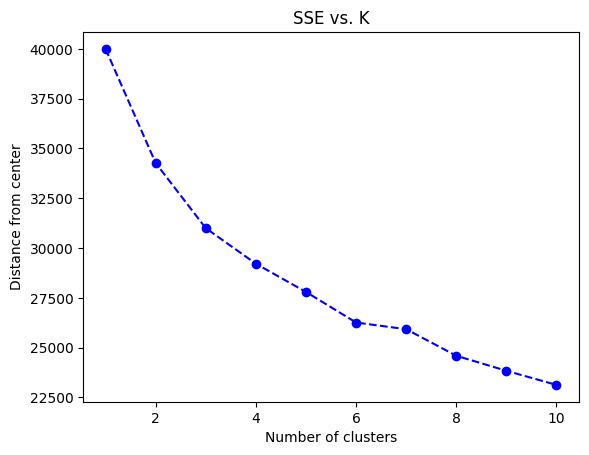

In [23]:
import matplotlib.pyplot as plt

plt.plot(ks, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of clusters');
plt.ylabel('Distance from center');
plt.title('SSE vs. K');

it shown that the optimal number of clusters is 2

In [24]:
kmeans_2 = KMeans(3)

# Then fit the model to your data using the fit method
kmeans_2 = kmeans_2.fit(df_merged_cleaned)

# Finally predict the labels on the same data to show the category that point belongs to
labels_2 = kmeans_2.predict(df_merged_cleaned)

### Plot the dataset before and after clustering (with number of clusters = 2)

In [25]:
import matplotlib.pyplot as plt

def plotData_2D(df_before_clustering, centroids, labels, title_, name1, name2):
    fig = plt.figure(figsize=(11, 5))
    fig.suptitle(title_, fontsize=16)

    # Plot data before clustering
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(df_before_clustering.iloc[:, 0], df_before_clustering.iloc[:, 1], alpha=0.5)
    ax1.set_title(name1)

    # Plot data after clustering
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(df_before_clustering.iloc[:, 0], df_before_clustering.iloc[:, 1], c=labels, alpha=0.5, cmap='tab10')

    # Plot centroids
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker="o", s=100, c='red', edgecolors="black", alpha=1, label="Centroids")

    ax2.set_title(name2)
    ax2.legend()
    plt.show()

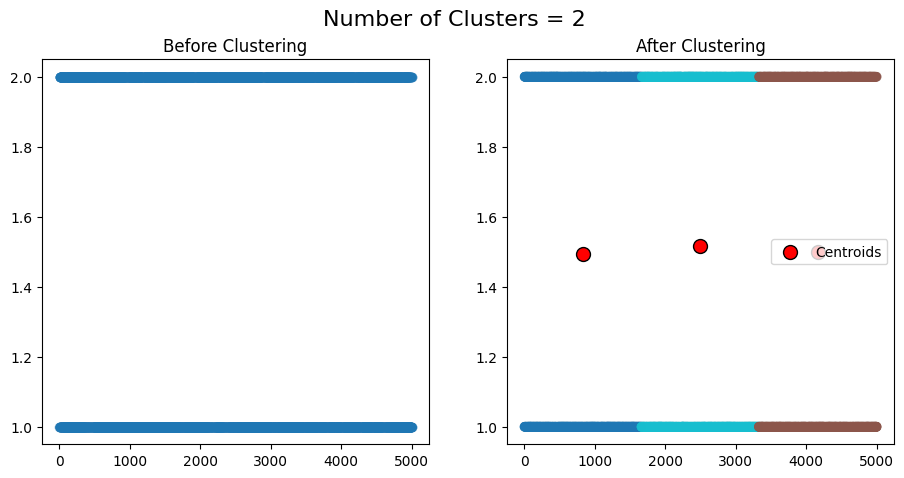

In [26]:
plotData_2D(df_merged_cleaned, kmeans_2.cluster_centers_, labels_2, 'Number of Clusters = 2', 'Before Clustering', 'After Clustering')